# Homework 11: Galaxy Detection Challenge (40 points)

name: Ying Jiang

email: jiangyyy@umich.edu

This homework assignment took me 15 hours in total to complete. (Please help us to gauge the difficulty of the assignment.)

## Collaboration Disclosure

In the cell below, please list *everyone* with whom you discussed any of the homework problems, excluding only the GSIs and the course instructor. 

If you did not discuss the homework with anyone else, write __"I did not discuss this homework with anyone."__

Even if you discuss questions with other, the code you submit must be only yours. All work is checked with the [MOSS plagiarism detector](https://theory.stanford.edu/~aiken/moss/).)

I did not discuss this homework with anyone.

## Introduction

For this homework, we are hosting a kaggle competition! We hope that you enjoy this opportunity to learn more about machine learning by tackling a real-world dataset and problem. Please take a look at the kaggle page of this competition https://www.kaggle.com/c/galaxy-detection-challenge. In kaggle you can find a leaderboard displaying how the class is doing in the public version of the test set results. 

This problem set is designed to be more __open-ended__, you should feel free to experiment with different algorithms or strategies to solve this challenge. We provide a basic implementation using a single layer feedforward neural network, you should feel free to experiment with other architectures and approaches. In the following we provide a non-exhaustive list. 

### Neural network architecture

Without changing the type of neural network, here are some changes you can try:

- changing the number of layers
- changing the activation function(s) (logistic sigmoid, tanh, relu, leaky relu, ...)
- modifying the # of hidden layers
- changing the # units in the hidden layer(s)

Other types of layers that might be useful include: 

- using drouput layers
- adding pooling layers
- adding batch-norm layers
- adding convolutional layers (since we are using images)

### Training

- running for more epochs (be careful to avoid over-fitting!)
- changing the minibatch size
- use data augmentation methods. 
- early stopping (choosing the model that does the best in a particular epoch even if you train it for longer)


### Optimizer 

- modifying the learning rate, weight_decay, or other parameters of the optimizers. 
- Try other optimizers from the `torch.optim` module. 

### Other approaches

- using ResNet style architecture 
- Divide the images into smaller tiles and then combine the results (why is this a good idea?) 
- Multi-step approaches, i.e. first employ one algorithm/network and then refine the result via another one.
- using the scipy peak-finding function. 
- normalizing the images (like in the baseline model below) 
- other preprocessing steps or [transformations](https://pytorch.org/docs/stable/torchvision/transforms.html) on the images.

__IMPORTANT:__ If you do borrow ideas from external sources to design your algorithm, please reference them explicitly in the **Conclusion** section at the end of this notebook.

## Deliverables

- Submit this jupyter notebook to Canvas as usual.

- A `.csv` file with the output of your algorithm on the `test.pt` images (submitted to kaggle).

**Hint:** At the end of this notebook, there is a function `output_to_csv` that you can use to create a `.csv` file that can be uploaded to kaggle for evaluation. 

## Submission to kaggle

You will need to access kaggle with the following link: 

https://www.kaggle.com/t/d88b1d95728848fe8d082fff446801fe

and create an account. If possible, please use your __umich email address__ and real name to register so that we can easily match your submission to your Canvas grade.

## Grading

Since this final project is open-ended and encouraged to be of a exploratory nature, we are not giving explicit accuracy thresholds that you must aim for to get a specific grade. Instead, you are encouraged to do your best in the time available and we will adjust the grading rubric depending on the submissions we get. We will carefully take into account effort and the results of your exploration for our grading - feel free to go into detail in the **Conclusion** section of this homework below. 

## Setup

In [1]:
%matplotlib inline
import os
import csv
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

C:\Users\57277\anaconda3_2020\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Data 

We have provided dataset with images of galaxies in `.pt` format (`pytorch` readable) consisting of the following files (included along this notebook in your Canvas download):

- train.pt

- valid.pt

- test.pt 

The training file contains __10k__ images of simulated galaxies, the validation contains __10k__ galaxies, and testing contains __10k__ galaxies. Each image can contain anything between **0 and 6 galaxies**. Each image has dimensions __20x20__ pixels. 

The **goal** of your algorithm is to determine the number of galaxies in a given image. You can think of this problem as a classification problem: given an input image we classify it as 1 of the 7 classes (whether the image contains 0, 1, ..., 6 galaxies).

**Note:** In total, we provided __20k__ images with the true labels which we split into the `train.pt` and `valid.pt` files provided above. Note that this separation of training and validation is ultimately up to you so you can change it if you want. 

### Overview

The __training set__ contains images and their true counts which can be accessed as follows: 

In [3]:
train_data = torch.load('train.pt')
train_images = train_data['images']
train_counts = train_data['counts']

print(train_images.shape) # = (10000, 20, 20)
print(train_counts.shape) # = (10000)

torch.Size([10000, 20, 20])
torch.Size([10000])


In [4]:
SLEN = train_images.shape[-1]

To be explicit, let $i$ be an index satisfying $0 < i < 10,000$, then `train_counts[i]` corresponds to the number of galaxies in the 20-by-20 image `train_images[i]`. 

Lets take a look at the first 4 images of galaxies to get an idea of what the data looks like and make sure you can load them correctly.

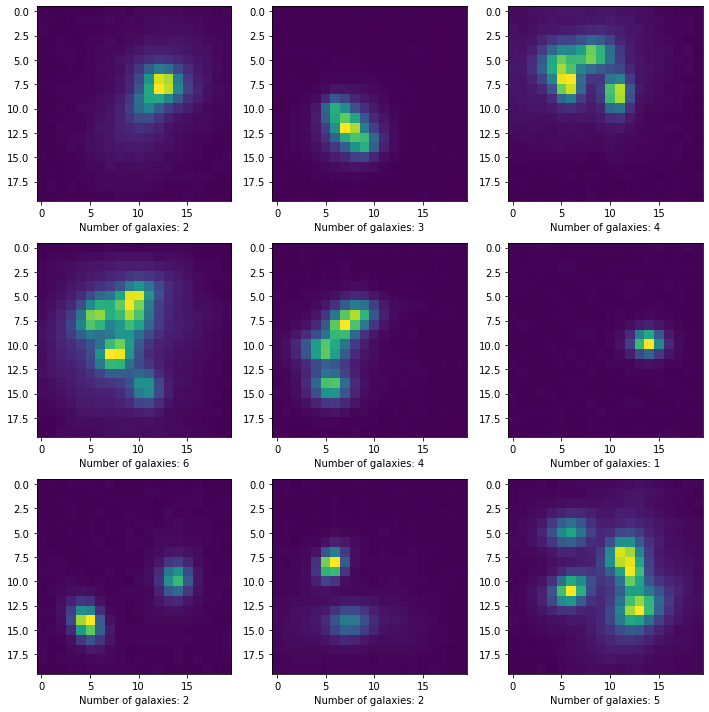

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))
axes = axes.flatten() # get a single dimensional array. 
for i in range(9):
    ax = axes[i]
    image = train_images[i].cpu().numpy()
    count = train_counts[i].item()
    ax.imshow(image)
    ax.set_xlabel(f"Number of galaxies: {count}")
plt.tight_layout()

The __testing set__ does not countain the counts of each image, your model will predict the counts and these will be evaluated in kaggle. You can access them like this:

In [6]:
test_set = torch.load('test.pt')
test_images = test_set['images'] 
assert 'count' not in test_set # does not include counts.
print(test_images.shape) # = (10000, 20, 20)

torch.Size([10000, 20, 20])


### Dataset and Dataloader

What follows is a skeleton for a pytorch `Dataset` and corresponding `DataLoaders` that can be used to train and test the model. You can modify this base implementation if you want, but it's not necessary for completing the problem set.

In [7]:
# You can modify these attributes if you want.
BATCH_SIZE = 32
N_WORKERS = 0  # number of cpus used to load the data faster.
assert N_WORKERS <= os.cpu_count(), "Your computer does not have enough CPUs."

In [8]:
from torch.utils.data import Dataset, DataLoader

class GalaxyDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""

    def __init__(self, filepath, test=False):
        self.data = torch.load(filepath)
        self.images = self.data['images']
        self.test = test
    
    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        
        if self.test: 
            return {'images': self.images[idx]}
        
        else: 
            return {'images': self.images[idx], 'counts': self.data['counts'][idx]}

In [9]:
# Define datasets and dataloaders. 
train_dataset = GalaxyDataset('train.pt', test=False)
valid_dataset = GalaxyDataset('valid.pt', test=False)
test_dataset = GalaxyDataset('test.pt', test=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=N_WORKERS)
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=N_WORKERS)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=N_WORKERS)

## Utility functions

In [10]:
def compute_accuracy(model, data_loader):
    """
    Takes in your model and either the train_dataloader and valid_dataloader above. Calculate the accuracy of
    your model in this dataset.

    NOTE: As explained below it assumes your model has a .predict() method. 
    """
    assert not data_loader.dataset.test, "Only works for train and valid dataloaders"
    assert hasattr(model, 'predict'), "your model does not have a '.predict()' method."
    correct_pred, n_examples = 0, 0
    with torch.no_grad():
        for batch in data_loader: 
            images = batch['images'].to(DEVICE)
            true_counts = batch['counts'].to(DEVICE)
            pred_counts = model.predict(images)
            n_examples += true_counts.size(0)
            correct_pred += (pred_counts == true_counts).sum()
        return correct_pred.float()/n_examples

In [11]:
def compute_epoch_loss(model, data_loader):
    """Computes the loss of your model given a train or validation dataloader.
    
    NOTE: Only works for the MLP architecture we have below, if you don't use the MLP architecture 
    then you might need to compute the loss differently. Feel free to modify this function.
    
    """
    curr_loss, n_examples = 0., 0
    with torch.no_grad():
        for batch in data_loader:
            images = batch['images'].to(DEVICE)
            true_counts = batch['counts'].to(DEVICE)
            logits, probs = model(images)
            loss = F.cross_entropy(logits, true_counts, reduction='sum')
            n_examples += true_counts.size(0)
            curr_loss += loss.item()

        curr_loss = curr_loss / n_examples
        return curr_loss

## Your model

### Implementation

Here were provide a baseline model based on a multi-layer perceptron like the one you saw in HW10. You have complete flexibility in the final implementation, including training and how your compute your loss. 

**Note:** The only requirement to be able to test your model is that your class has a method `.predict()` that takes in images of shape `(N, 20, 20)` and returns an array of shape `(N)` containing the prediction for the number of galaxies in each of the images. 

In [12]:
# the random seed makes sure that the random weight initialization
# in the model is always the same.
# Depending on your architecture you might want to try different seeds since some seeds could correspond
# to a bad initialization.
RANDOM_SEED = 125
torch.manual_seed(RANDOM_SEED)
print("Seed is", RANDOM_SEED)

Seed is 125


In [13]:
class MLP(torch.nn.Module):

    def __init__(self, n_hidden=50, n_classes=7):
        """A standard MLP with 1 hidden layer. 
        
        Arguments: 
            n_hidden: Number of units in the first hidden layer. 
            n_classes: Number of classes. Should be 7, the possible number of galaxies in the image.
        """
        super(MLP, self).__init__()
        n_features=SLEN**2
        self.linear = torch.nn.Linear(n_features, n_hidden)
        self.linear_out = torch.nn.Linear(n_hidden, n_classes)
        


    def forward(self, x):
        """Forward function that takes in x, a tensor of shape (N, 20, 20) of galaxy images and 
        returns a prediction.
        
        Returns: 
            logits: Output of the feedfoward neural networs (unnormalized log-probabilities) 
            probs: normalized probabilities. 
        """
        assert len(x.shape) == 3
        assert x.shape[1] == x.shape[2]
        x = x.reshape(-1, SLEN**2) # flatten because we are doing a linear pass. 
        x = x / x.mean(axis=1).reshape(-1, 1) # I find that normalizing helps. 
        out = self.linear(x)
        out = torch.tanh(out)
        #out = F.relu(out)
        out = torch.sigmoid(out)
        logits = self.linear_out(out)
        probs = F.softmax(logits, dim=1)
        return logits, probs
    
    def predict(self, x):
        logits, probs = self(x)
        return probs.argmax(axis=1).int()

In [14]:
class MLP(torch.nn.Module):

    def __init__(self, n_hidden=54, n_classes=7):
        """A standard MLP with 1 hidden layer. 
        
        Arguments: 
            n_hidden: Number of units in the first hidden layer. 
            n_classes: Number of classes. Should be 7, the possible number of galaxies in the image.
        """
        super(MLP, self).__init__()
        self.l1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.l2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.classifier = nn.Sequential(
            torch.nn.Linear(800, n_hidden),
            #torch.nn.Tanh(),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(n_hidden, n_classes)
            
        )
        


    def forward(self, x):
        """Forward function that takes in x, a tensor of shape (N, 20, 20) of galaxy images and 
        returns a prediction.
        
        Returns: 
            logits: Output of the feedfoward neural networs (unnormalized log-probabilities) 
            probs: normalized probabilities. 
        """
        x = x.reshape(-1,1, 20, 20)
        x = self.l1(x)
        x = self.l2(x)
        d = x.shape[0]
        x = x.reshape(d,-1)
        #x = x / x.mean(axis=1).reshape(-1, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits,probs
    
    def predict(self, x):
        logits, probs = self(x)
        return probs.argmax(axis=1).int()

### Initializiation

You should create your model from the class specified above this cell. You __should__ move your model to the correct device by using the `.to(DEVICE)` method.

In [24]:
model = MLP(n_hidden=120, n_classes=7)
model = model.to(DEVICE)

### Optimizer

You can feel free to experiment with different optimizers and learning rates, etc. If you do, this is a good thing to write in the conclusions at the end of this notebook. 

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

## Training

Depending on how much you changed your architecture, your training procedure might change. If you are still using a MLP it's very likely you can keep the same training procedure. 

You can also modify the number of epochs below, as an input argument to `run_training`.

In [26]:
def run_training(model, train_loader, valid_loader, n_epochs=10):
    start_time = time.time()
    epoch_loss = [] 
    for epoch in range(n_epochs):
        model.train()
        for batch_idx, batch in enumerate(train_loader):
            images = batch['images'].to(DEVICE)
            true_counts = batch['counts'].to(DEVICE)


            # FORWARD AND BACK PROP
            
            logits, probs = model(images)
            cost = F.cross_entropy(logits, true_counts)
            optimizer.zero_grad()
            cost.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            if not batch_idx % 50:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f'
                      % (epoch+1, n_epochs, batch_idx,
                         len(train_loader), cost))

        # we evaluate our model after each epoch.
        model.eval()
        cost = compute_epoch_loss(model, train_loader)
        epoch_loss.append(cost)

        train_accuracy = compute_accuracy(model, train_loader)
        valid_accuracy = compute_accuracy(model, valid_loader)

        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, n_epochs, cost))
        print('Train Accuracy: %.3f | Validation Accuracy: %.3f'
              % (train_accuracy, valid_accuracy))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    return train_accuracy, valid_accuracy, epoch_loss

In [27]:
N_EPOCHS = 10

train_accuracy, valid_accuracy, epoch_loss = run_training(model, train_loader, valid_loader, n_epochs=N_EPOCHS)

Epoch: 001/010 | Batch 000/313 | Cost: 1.9031
Epoch: 001/010 | Batch 050/313 | Cost: 1.5675
Epoch: 001/010 | Batch 100/313 | Cost: 1.3422
Epoch: 001/010 | Batch 150/313 | Cost: 1.3650
Epoch: 001/010 | Batch 200/313 | Cost: 1.3291
Epoch: 001/010 | Batch 250/313 | Cost: 1.2529
Epoch: 001/010 | Batch 300/313 | Cost: 1.0162
Epoch: 001/010 Train Cost: 0.9162
Train Accuracy: 0.668 | Validation Accuracy: 0.666
Time elapsed: 0.22 min
Epoch: 002/010 | Batch 000/313 | Cost: 1.0096
Epoch: 002/010 | Batch 050/313 | Cost: 0.9817
Epoch: 002/010 | Batch 100/313 | Cost: 0.8141
Epoch: 002/010 | Batch 150/313 | Cost: 0.9448
Epoch: 002/010 | Batch 200/313 | Cost: 0.9596
Epoch: 002/010 | Batch 250/313 | Cost: 0.9047
Epoch: 002/010 | Batch 300/313 | Cost: 0.7027
Epoch: 002/010 Train Cost: 0.7099
Train Accuracy: 0.760 | Validation Accuracy: 0.756
Time elapsed: 0.43 min
Epoch: 003/010 | Batch 000/313 | Cost: 0.9354
Epoch: 003/010 | Batch 050/313 | Cost: 0.8580
Epoch: 003/010 | Batch 100/313 | Cost: 0.8722
Ep

### Loss function

Here is a plot showing your loss as a function of epoch which can be used to see if your model is being optimized correctly. This could also help you decide if e.g. **early stopping** might be helpful. 

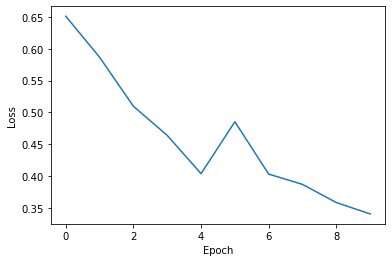

In [19]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Testing 

Once you trained your `model`, you are ready to try it out in the `test_images`. Even though we don't provide the true counts for the test images, you can inspect some by eye if you want. 

**WARNING:** Do not modify the order of `my_counts` otherwise your submission to kaggle will be wrong. 

In [20]:
my_counts = torch.zeros(0, device=DEVICE) 
model.eval()
for batch in test_loader:
    test_pred = model.predict(batch['images'].to(DEVICE))
    my_counts = torch.cat((my_counts, test_pred), 0)

## Submission (20 points) 

Once you are satisfied with your model and your predictions, you are ready to submit to [kaggle](https://www.kaggle.com/c/galaxy-detection-challenge). We provide the function `counts_to_csv` that automatically takes in your prediction for the test set and creates a CSV file that you can upload to kaggle for your submission. This file will be created in the same directory as your notebook.

In [21]:
import csv
def counts_to_csv(uniqid, counts):
    assert len(counts.shape) == 1, "Incorrect format for counts."
    assert counts.shape[0] == 10000, "Incorrect format for counts."
    with open(f'{uniqid}.csv', 'w', newline='') as fp: 
        writer = csv.writer(fp)
        writer.writerow(['ID', 'Category'])
        for i, c in enumerate(counts):
            writer.writerow([str(i), str(int(c.item()))])

In [22]:
# Please enter your uniqID below
your_uniqid = 'EXAMPLE'

In [23]:
counts_to_csv(your_uniqid, my_counts) # creates a file in your current directory called `UNIQID.csv`.

## Conclusion (20 points)

In the cell below, please describe the approach you took in designing your algorithm and the choices that went into this design. Your answer should be detailed and will be significantly weighted in determining your final grade. Your answer might include but is not limited to the following points: 

- What type of neural network architecture did you use? (CNN, MLP, ResNet, etc.) How many layers did you use? How many units in each layer? How did you initialize your neural network? What optimizer did you use? 

- What challenges did you encounter as you were doing this problem set? How did you overcome these obstacles?

- Please explain your overall design and the choices behind it as much as possible (this can include your thought process). 

- How many different designs did you try? How did you settle on your final design?

- If you used external resources to get any ideas for your solution, please describe these too.

1. CNN. 
   I used 3 sequences of layers, the first one contains a 2-d convolution layer(1 input channel, 16 output channels, kernel_size=5, stride=1, padding=2), a 2-d BatchNorm layer, a ReLu layer, a MaxPool2d layer(kernel_size=2, stride=2);the second one contains a 2-d convolution layer(16 input channel, 32 output channels, kernel_size=5, stride=1, padding=2), a 2-d BatchNorm layer, a ReLu layer, a MaxPool2d layer(kernel_size=2, stride=2) and the last one contains a Linear layer(num_hidden=120),a ReLU layer, a Dropout layer, a linear layer(n_classes=7) and a softmax layer.
   I initialed my neural network with BATCH_SIZE = 32, N_WORKERS = 0.
   I used Adam optimizer(learning rate=0.0005).
2. After I added the 2-d convolution layers, I found that the shape of data could not fit the model, thus I had to reshape it to (-1, 1, 20, 20). What's more, in order to get higher accuracy, I had to constantly adjust the parameters. 
3. My overall design is two blocks of covolutions and one block of classifier. I chose CNN to solve the problem because it has better performance in dealing with images than simple MLP. At first I only used one block of covolution but the accuracy was pretty low, so I added another one which made the result better but not good enough. Thus I added BatchNorm layers to avoid overfitting problems and the result now seems quite well. As for the classifier, I also used a Dropout layer to avoid overfitting.
4. At the beginning I did not use covolution layers, the highest accuracy was about 0.72. Then I used CNN with only one block of covolution, but the accuracy fell down to 0.4 so I added another one. After hardwork of adjusting the parameters, the accuracy is about 0.87 now.
5. I did not use external resources.